# Testing XGB on well log datasets 

In [1]:
import numpy as np
import pandas as pd

from coremdlr.datasets import WellLoader, FaciesDataset
from coremdlr.models import FeaturePredictor, LambdaModel

Using TensorFlow backend.


In [2]:
from coremdlr.datasets.utils import available_wells

wells = list(available_wells())
wells, len(wells)

(['204-19-3A',
  '204-20-1Z',
  '204-19-7',
  '204-24a-7',
  '204-20-1',
  '204-19-6',
  '205-21b-3',
  '204-20-6a',
  '204-20a-7',
  '204-24a-6',
  '204-20-2',
  '204-20-3'],
 12)

### Picking your training and testing wells

In [3]:
fdset = FaciesDataset(wells[:10], test_wells=wells[10:],
                    features=["logs"],
                    label_resolution=32*50, # 32 pixels ~ .5cm
                    logs_args={'scaler_kind': 'standard'})

In [4]:
fdset.load_or_generate_data()

Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (197,)), ('top', (197,)), ('base', (197,)), ('logs', (197, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (39,)), ('top', (39,)), ('base', (39,)), ('logs', (39, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (199,)), ('top', (199,)), ('base', (199,)), ('logs', (199, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (401,)), ('top', (401,)), ('base', (401,)), ('logs', (401, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (236,)), ('top', (236,)), ('base', (236,)), ('logs', (236, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (36,)), ('top', (36,)), ('base', (36,)), ('logs', (36, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (81,)), ('top', (81,)), ('base', (81,)), ('logs', (81, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (72,)), ('top', (72,)), ('base', (72,)), ('logs', (72, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (64,)), ('top', (64,)), ('base', (64,)), ('logs', (64, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (273,)), ('top', (273,)), ('base', (273,)), ('logs', (273, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (60,)), ('top', (60,)), ('base', (60,)), ('logs', (60, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (225,)), ('top', (225,)), ('base', (225,)), ('logs', (225, 11))]


In [5]:
import hyperopt

from hyperopt import hp
from hyperopt.pyll.base import scope
from sklearn.metrics import f1_score, log_loss
from sklearn.utils.class_weight import compute_sample_weight

# for balanced log_loss computation
sample_weights = compute_sample_weight('balanced', fdset.y_test) 

fmodel_args = {
    'logs': {
        'model': 'LambdaModel',
        'model_args': {'feature': 'logs'}
    }
}

XGB_SEARCH_SPACE = {
    'model_type' : 'XGB',
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 1000, 1)),
    'objective' : 'multi:softprob',
    'n_jobs' : 2,
    'gamma' : hp.uniform('gamma', 0, 0.5),
    'subsample' : hp.uniform('subsample', 0.3, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1.0),
    'colsample_bylevel' : 1,
    'reg_alpha' : 0,                                    # L1 penalty
    'reg_lambda' : hp.uniform('reg_lambda', 0.1, 10),   # L2 penalty
    'tree_method' : 'gpu_exact',
}

def train_xgb_model(model_config):
    """
    Train function given model_config dict of params.
    """
    xgb_predictor = FeaturePredictor(fdset, model_args=model_config, feature_model_args=fmodel_args)
    test_acc = xgb_predictor.fit(fdset, verbose=False)
    y_pred = xgb_predictor.predict(fdset.X_test)
    print('F1 score:', f1_score(fdset.y_test, y_pred, average='macro'))
    return log_loss(fdset.y_test, xgb_predictor.predict_proba(fdset.X_test), sample_weight=sample_weights)


def make_params_usable(params):
    """
    Convert params returned by hyperopt to usable `model_args`
    """
    return {
        **XGB_SEARCH_SPACE,
        **params,
        **{'max_depth' : int(params['max_depth']),
           'n_estimators' : int(params['n_estimators'])}
    }

In [6]:



best_params = hyperopt.fmin(
    fn=train_xgb_model,
    space=XGB_SEARCH_SPACE,
    algo=hyperopt.rand.suggest,
    max_evals=50
)

Training model for feature:  logs
F1 score: 0.16362151186703205
Training model for feature:  logs
F1 score: 0.1601668056713928
Training model for feature:  logs
F1 score: 0.14532777543983993
Training model for feature:  logs
F1 score: 0.1176269052221568
Training model for feature:  logs
F1 score: 0.13459630096358247
Training model for feature:  logs
F1 score: 0.15902621076506313
Training model for feature:  logs
F1 score: 0.13189298245614037
Training model for feature:  logs
F1 score: 0.15279745579414453
Training model for feature:  logs
F1 score: 0.15828529397445862
Training model for feature:  logs
F1 score: 0.17571690210899676
Training model for feature:  logs
F1 score: 0.13416957026713122
Training model for feature:  logs
F1 score: 0.12635621521335808
Training model for feature:  logs
F1 score: 0.13228430397034435
Training model for feature:  logs
F1 score: 0.11149449432701901
Training model for feature:  logs
F1 score: 0.1699067923822744
Training model for feature:  logs
F1 score:

In [7]:
best_params

{'colsample_bytree': 0.8793404631412298,
 'gamma': 0.43774364836086044,
 'learning_rate': 0.046170495867596695,
 'max_depth': 9.0,
 'n_estimators': 15.0,
 'reg_lambda': 4.131428404944846,
 'subsample': 0.4788196091733915}

In [8]:
params = {
    **XGB_SEARCH_SPACE, 
    **best_params, 
    **{'max_depth' : int(best_params['max_depth']), 
       'n_estimators' : int(best_params['n_estimators'])}
}
xgb_predictor = FeaturePredictor(fdset, model_args=params, feature_model_args=fmodel_args)
xgb_predictor.fit(fdset, verbose=True)

imps = list(zip(fdset.wells[0].logs_args['which_logs'], xgb_predictor.model.feature_importances_))
imps.sort(key = lambda p: p[1])
for pair in imps[::-1]:
    print(pair)

Training model for feature:  logs
                      precision    recall  f1-score   support

           sandstone       0.35      0.25      0.29        96
clay-prone sandstone       0.29      0.05      0.09       120
      sandy mudstone       0.00      0.00      0.00        11
          oilstained       0.17      0.19      0.18        48
            mudstone       0.02      0.30      0.04        10

           micro avg       0.15      0.15      0.15       285
           macro avg       0.17      0.16      0.12       285
        weighted avg       0.27      0.15      0.17       285

Total accuracy Score :  0.14736842105263157
Confusion Matrix: 
 [[24 11  0 17 44]
 [34  6  5 19 56]
 [ 3  0  0  1  7]
 [ 8  4  0  9 27]
 [ 0  0  0  7  3]]
('DENS', 0.11621752)
('PEF', 0.11453321)
('RDEP', 0.10490856)
('GR', 0.10153994)
('SP', 0.10057748)
('DTC', 0.10009625)
('NEUT', 0.08902791)
('DTS', 0.0753128)
('RSHAL', 0.07001925)
('DTS1', 0.06953802)
('DTS2', 0.058229066)


/home/administrator/code/python/coremdlr/coremdlr/viz/__init__.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/administrator

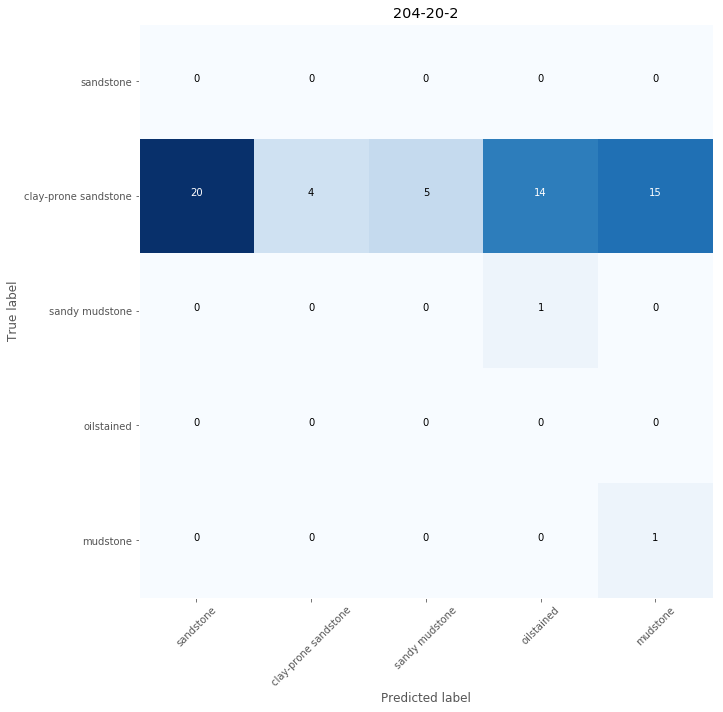

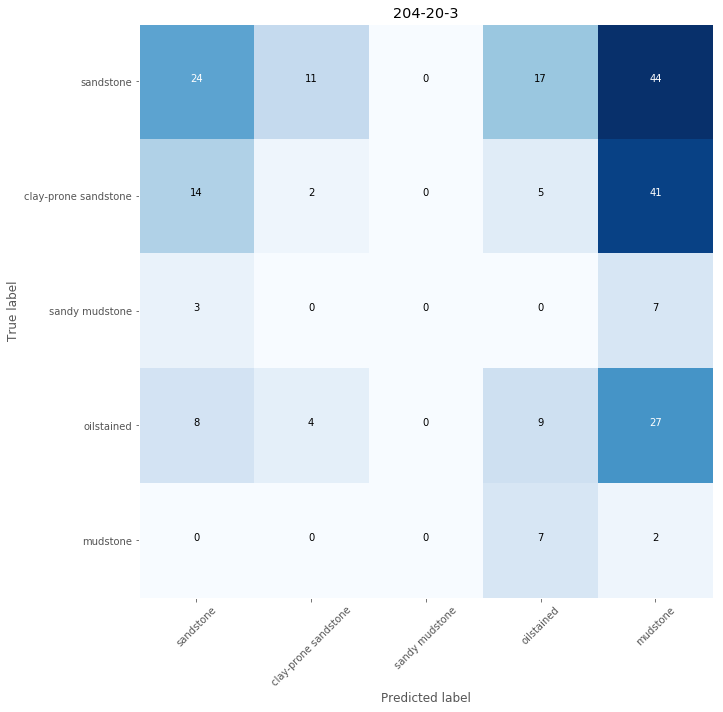

In [9]:
import matplotlib.pyplot as plt
from coremdlr.viz import model_plots 

pred_dfs = []

for test_well_name in fdset.test_well_names:
    df = xgb_predictor.preds_dataframe(test_well_name, logs=fdset.logs_args['which_logs'])
    df['well'] = test_well_name
    
    fig, ax = plt.subplots(figsize=(10,10))
    model_plots.confusion_matrix_plot(df, fdset.classes, title=test_well_name, ax=ax)
    
    pred_dfs.append(df)
    
pred_df = pd.concat(pred_dfs)

In [10]:
fdset.classes

['sandstone',
 'clay-prone sandstone',
 'sandy mudstone',
 'oilstained',
 'mudstone']